In [5]:
# installing package
!pip install tensorflow-addons

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPool2D,#Normalization,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add
)
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split

2022-10-31 11:56:05.867693: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [7]:
img_shape = (28,28,1)
epochs = 100
batch = 16

In [8]:
# kaggle dataset inputs
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

In [9]:
# reshape test data
testing = test.to_numpy().reshape(28000,28,28,1)

In [10]:
# input feature
x = train.iloc[:,1:]
# target feature 
y = train.iloc[:,:1]

In [11]:
# train test split process. %80 train - %20 test
train_x, val_x, train_y,val_y = train_test_split(x,y, test_size=0.2,
                                                stratify=y)

print(train_x.shape,train_y.shape)
print(val_x.shape,val_y.shape)

(33600, 784) (33600, 1)
(8400, 784) (8400, 1)


## Vision Transformer


In [28]:
input_shape = (28,28,1)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 10
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

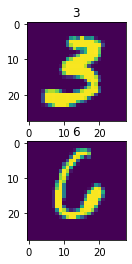

In [15]:
# transform function
def gen(data_x,data_y):
    for x in range(len(data_x)):
        y = np.zeros(10)
        tmp = data_x[x]
        input_ = tmp.reshape(img_shape)/255.
        y[int(data_y[x][0])] = 1.
        input_ = tf.convert_to_tensor(input_,dtype=tf.float32)
        y = tf.convert_to_tensor(y,dtype=tf.float32)
        yield input_,data_y[x]
        
train_dataset = tf.data.Dataset.from_generator(gen,
                                         (tf.float32,tf.float32),
                                         ((img_shape),(1)),
                                         args=(train_x,train_y))
val_dataset = tf.data.Dataset.from_generator(gen,
                                         (tf.float32,tf.float32),
                                         (img_shape,(1)),
                                         args=(val_x,val_y))
train_dataset = train_dataset.shuffle(128).batch(batch_size)
val_dataset = val_dataset.shuffle(128).batch(batch_size)

for image, label in train_dataset.take(1):
    print(label)
    for i in range(batch_size):
        plt.subplot(4,4,i+1)
        plt.imshow(image[i])

plt.show()

In [18]:
# Data Augmentation: Normalization, resizing, horizontal flip, random rotation, random zoom
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

In [20]:
# MLP
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [22]:
# Patch class
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 36


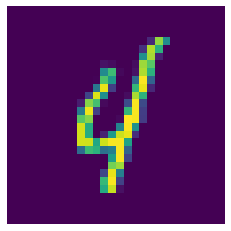

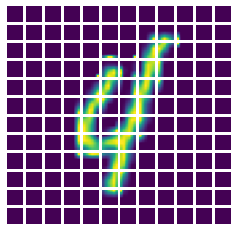

In [23]:
# Splitting images to patches
plt.figure(figsize=(4, 4))
image = train_x.iloc[0].to_numpy().reshape((28,28,1))
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [24]:
# Encoding patching for the model inputs
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [25]:
# transformer model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(10)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [26]:
# Training process
def run_experiment(model):
    # AdamW optimizer
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    # Compile model. Loss function sparse categorical crossentropy
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    # Saving weights
    checkpoint_filepath = "./"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train_dataset,validation_data=val_dataset,
        batch_size=batch_size,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )
    # Loading saving weights, finding top 5 accuracy
    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(val_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    return history

In [29]:
# Training
vit_classifier = create_vit_classifier()
vit_history = run_experiment(vit_classifier)

Epoch 1/10


2022-10-31 11:57:50.768753: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


      1/Unknown - 11s 11s/step - loss: 5.1261 - accuracy: 0.0000e+00 - top-5-accuracy: 0.2500

2022-10-31 11:57:51.747847: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


2100/2100 [==============================] - 105s 45ms/step - loss: 1.7933 - accuracy: 0.5681 - top-5-accuracy: 0.8997 - val_loss: 0.2648 - val_accuracy: 0.9226 - val_top-5-accuracy: 0.9962
Epoch 2/10
2100/2100 [==============================] - 95s 45ms/step - loss: 0.4558 - accuracy: 0.8629 - top-5-accuracy: 0.9910 - val_loss: 0.1775 - val_accuracy: 0.9462 - val_top-5-accuracy: 0.9965
Epoch 3/10
2100/2100 [==============================] - 94s 45ms/step - loss: 0.3496 - accuracy: 0.8939 - top-5-accuracy: 0.9932 - val_loss: 0.1185 - val_accuracy: 0.9624 - val_top-5-accuracy: 0.9987
Epoch 4/10
2100/2100 [==============================] - 94s 45ms/step - loss: 0.2463 - accuracy: 0.9256 - top-5-accuracy: 0.9967 - val_loss: 0.1062 - val_accuracy: 0.9668 - val_top-5-accuracy: 0.9995
Epoch 5/10
2100/2100 [==============================] - 94s 45ms/step - loss: 0.2255 - accuracy: 0.9351 - top-5-accuracy: 0.9967 - val_loss: 0.1312 - val_accuracy: 0.9613 - val_top-5-accuracy: 0.9987
Epoch 6/10

In [30]:
# loading saved weights for prediction
model = create_vit_classifier()
model.load_weights('./')

In [34]:
pred = model.predict(testing)

In [35]:
preds = []
for x in pred:
    preds.append(np.argmax(x))

In [36]:
sub['Label'] = preds

In [37]:
sub.to_csv('sub.csv')

In [38]:
# Submission displaying
sub.head()

,ImageId,Label
0,1,2
1,2,2
2,3,4
3,4,4
4,5,3
